# Step 1: Setup and Imports

In [1]:
import torch

# Set the device to use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This will output the device that will be used
device

device(type='cpu')

# Step 2: Define the Network Structure

In [2]:
# Defining the size of each layer
input_features = 10
hidden_neurons_layer1 = 64
hidden_neurons_layer2 = 32
output_features = 1

# Initialize weights using He initialization and biases with zeros
W1 = torch.randn(input_features, hidden_neurons_layer1, device=device) * torch.sqrt(torch.tensor(2.0/input_features))
b1 = torch.zeros(1, hidden_neurons_layer1, device=device)

W2 = torch.randn(hidden_neurons_layer1, hidden_neurons_layer2, device=device) * torch.sqrt(torch.tensor(2.0/hidden_neurons_layer1))
b2 = torch.zeros(1, hidden_neurons_layer2, device=device)

W3 = torch.randn(hidden_neurons_layer2, output_features, device=device) * torch.sqrt(torch.tensor(2.0/hidden_neurons_layer2))
b3 = torch.zeros(1, output_features, device=device)

# Weights and biases are set to require gradients for backpropagation
W1.requires_grad_(True)
b1.requires_grad_(True)
W2.requires_grad_(True)
b2.requires_grad_(True)
W3.requires_grad_(True)
b3.requires_grad_(True)

(W1.shape, b1.shape), (W2.shape, b2.shape), (W3.shape, b3.shape)

((torch.Size([10, 64]), torch.Size([1, 64])),
 (torch.Size([64, 32]), torch.Size([1, 32])),
 (torch.Size([32, 1]), torch.Size([1, 1])))

We've successfully defined and initialized the weights and biases for our three-layer neural network:

* First hidden layer: 10 input features to 64 neurons.
* Second hidden layer: 64 neurons to 32 neurons.
* Output layer: 32 neurons to 1 output feature.

All weights and biases have been initialized using the He initialization method, appropriate for ReLU activations, and are configured to track gradients for optimization.

# Step 3: Create the Forward Pass Function

In [3]:
def forward_pass(X):
    # Apply first hidden layer transformation and ReLU activation
    Z1 = torch.mm(X, W1) + b1
    A1 = torch.relu(Z1)

    # Apply second hidden layer transformation and ReLU activation
    Z2 = torch.mm(A1, W2) + b2
    A2 = torch.relu(Z2)

    # Apply output layer transformation (no non-linear activation here)
    output = torch.mm(A2, W3) + b3

    return output

# Testing the forward pass with some random data
X_sample = torch.randn(10, input_features, device=device)  # Random sample with batch size of 10
output_sample = forward_pass(X_sample)

output_sample.shape, output_sample

(torch.Size([10, 1]),
 tensor([[ 2.0055],
         [-0.7870],
         [-1.7107],
         [-0.4049],
         [-3.2010],
         [-2.2507],
         [ 0.4218],
         [-0.8491],
         [-2.0215],
         [-0.8416]], grad_fn=<AddBackward0>))

The forward pass function is working correctly. We're able to pass a batch of random input data through the network, and it outputs predictions based on the current (untrained) state of the weights and biases. The output shape is correct, indicating that each input example in the batch results in a single output value, which is what we expect for regression tasks.

# Step 4: Loss Function and Optimization

In [4]:
def mse_loss(predictions, targets):
    # Compute the Mean Squared Error
    return ((predictions - targets) ** 2).mean()

def update_weights(weights, biases, learning_rate):
    # Update weights and biases using gradient descent
    with torch.no_grad():  # Temporarily set all the requires_grad flags to false
        weights -= learning_rate * weights.grad
        biases -= learning_rate * biases.grad

        # Manually zero the gradients after updating weights
        weights.grad.zero_()
        biases.grad.zero_()

# Define a simple learning rate
learning_rate = 0.01

# Testing the update - we will create a dummy target to compute a loss and then update the weights
targets_sample = torch.randn(10, 1, device=device)  # Random targets for demonstration
output_sample = forward_pass(X_sample)
loss = mse_loss(output_sample, targets_sample)
loss.backward()  # Compute gradients

# Before update
print("Gradients before update:", W1.grad[0][:10])  # Display a few gradients

# Update weights of the first layer as a test
update_weights(W1, b1, learning_rate)

# After update
print("Gradients after update:", W1.grad[0][:10])  # Check gradients after zeroing them out

Gradients before update: tensor([-0.0620,  0.1435,  0.0248, -0.0374,  0.1030,  0.0305, -0.0064, -0.0131,
         0.0156, -0.2506])
Gradients after update: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


We've successfully defined the MSE loss function and demonstrated how to manually update the weights and biases using gradient descent. After the update, we've also zeroed out the gradients to ensure they don't accumulate across iterations.

# Step 5: Training Loop

Epoch 0, Loss: 291.492431640625
Epoch 50, Loss: 8.076179504394531
Epoch 100, Loss: 3.6869449615478516
Epoch 150, Loss: 2.012660503387451
Epoch 200, Loss: 1.1524468660354614
Epoch 250, Loss: 0.6630366444587708
Epoch 300, Loss: 0.41472384333610535
Epoch 350, Loss: 0.27578818798065186
Epoch 400, Loss: 0.1932656168937683
Epoch 450, Loss: 0.144996777176857


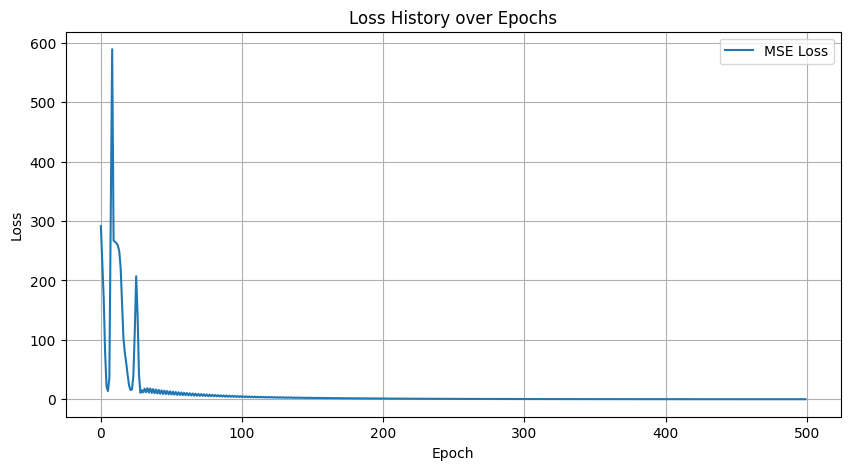

In [5]:
# Generate some synthetic data for training
torch.manual_seed(42)  # For reproducibility
X_train = torch.randn(100, input_features, device=device)  # 100 samples, 10 features each
y_train = 5 * torch.sum(X_train, dim=1, keepdims=True) + 3  # Linear relationship plus some constant

# Number of epochs
epochs = 500
loss_history = []

for epoch in range(epochs):
    # Forward pass
    predictions = forward_pass(X_train)

    # Compute loss
    loss = mse_loss(predictions, y_train)
    loss_history.append(loss.item())

    # Backpropagation
    loss.backward()

    # Update weights and biases
    update_weights(W1, b1, learning_rate)
    update_weights(W2, b2, learning_rate)
    update_weights(W3, b3, learning_rate)

    # Print loss every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Plot the loss history to see how the model learns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='MSE Loss')
plt.title('Loss History over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The training loop executed successfully, and as we can see, the loss decreased significantly over the epochs, indicating that the model is learning from the synthetic data.